In [13]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import math
import scipy.stats as scs
import cplex
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

In [14]:
# Read Daily Prices

# CSV file with price data
input_file_prices  = 'Daily_closing_prices.csv'
if path.exists(input_file_prices):
    print('\nReading daily prices datafile - {}\n'.format(input_file_prices))
    fid = pd.read_csv(input_file_prices)
    # instrument tickers
    tickers = list(fid.columns)[1:]
    # time periods
    dates = fid['Date']
    data_prices = fid.values[:,1:]
else:
    print("No such file '{}'".format(input_file_prices), file=sys.stderr)
    
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(fid['Date'].apply(convert_date_to_array)))


Reading daily prices datafile - Daily_closing_prices.csv



### Question 1, part 1

In [15]:
# Specify quantile level for VaR/CVaR
alf = 0.95

# Number of assets in universe
Na = data_prices.shape[1]

# Number of historical scenarios
Ns = data_prices.shape[0]

# Positions in the portfolio
positions = np.array([100, 0, 0, 0, 0, 0, 0, 0, 200, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(Na,1)

# historical 1-day
port_value = np.dot(data_prices,positions)
port_value = port_value.reshape((505,))
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
N = len(PLData)
VaR1 = loss_1d[int(math.ceil(N * alf)) - 1]
CVaR1 = (1 / (N * (1 - alf))) * ((math.ceil(N * alf) - N * alf) * VaR1 + sum(loss_1d[int(math.ceil(N * alf)):]))

# normal 1-day
VaR1n = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)
CVaR1n = np.mean(loss_1d) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss_1d)

# historical 10-day
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window = rolling_window(port_value, 10)
buffer_list = []
for i in range(window.shape[0]):
    buffer_list.append(window[i][-1]-window[i][0])
PLData = np.asarray(buffer_list)
loss_10d = np.sort(-PLData)
N = len(PLData)
VaR10 = loss_10d[int(math.ceil(N * alf)) - 1]
CVaR10 = (1 / (N * (1 - alf))) * ((math.ceil(N * alf) - N * alf) * VaR10 + sum(loss_10d[int(math.ceil(N * alf)):]))

# normal 10-day
VaR10n = np.mean(loss_10d) + scs.norm.ppf(alf) * np.std(loss_10d)
CVaR10n = np.mean(loss_10d) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss_10d)

print('Historical 1-day VaR %4.1f%% = $%6.2f,   Historical 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1, 100*alf, CVaR1))
print('    Normal 1-day VaR %4.1f%% = $%6.2f,       Normal 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1n, 100*alf, CVaR1n))
print('Historical 10-day VaR %4.1f%% = $%6.2f,   Historical 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10, 100*alf, CVaR10))
print('    Normal 10-day VaR %4.1f%% = $%6.2f,       Normal 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10n, 100*alf, CVaR10n))


Historical 1-day VaR 95.0% = $2477.25,   Historical 1-day CVaR 95.0% = $4326.98

    Normal 1-day VaR 95.0% = $2646.49,       Normal 1-day CVaR 95.0% = $3339.94

Historical 10-day VaR 95.0% = $8472.11,   Historical 10-day CVaR 95.0% = $13113.38

    Normal 10-day VaR 95.0% = $6842.63,       Normal 10-day CVaR 95.0% = $8764.32



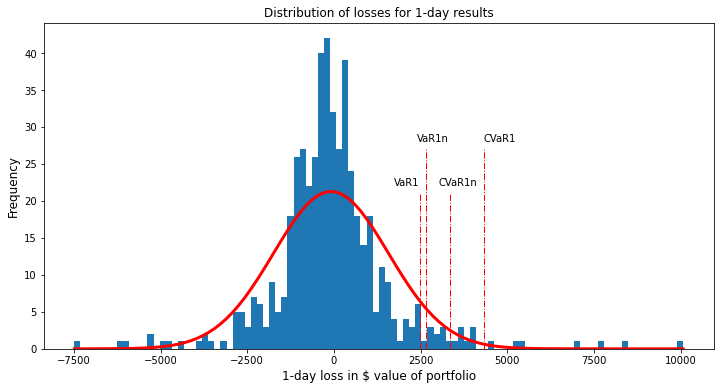

In [16]:
# distribution of losses for 1-day results
plt.figure(figsize=(12,6))
loss_1d = loss_1d.astype(float)
frequencyCounts, binLocations, patches = plt.hist(loss_1d, 100)
normf = (1 / (np.std(loss_1d) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_1d)) / np.std(loss_1d)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaR1, VaR1], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaR1n, VaR1n], [0, max(frequencyCounts) / 1.55], color='r', linewidth=1, linestyle='-.')
plt.text(0.7 * VaR1, max(frequencyCounts) / 1.9, 'VaR1')
plt.text(0.9 * VaR1n, max(frequencyCounts) / 1.5, 'VaR1n')
plt.plot([CVaR1, CVaR1], [0, max(frequencyCounts)/1.55], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaR1n, CVaR1n], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.text(1 * CVaR1, max(frequencyCounts) / 1.5, 'CVaR1')
plt.text(0.9 * CVaR1n, max(frequencyCounts) / 1.9, 'CVaR1n')
plt.title("Distribution of losses for 1-day results")
plt.xlabel('1-day loss in $ value of portfolio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

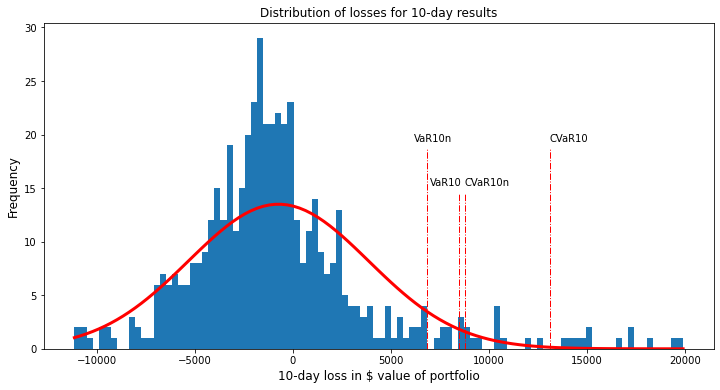

In [17]:
# distribution of losses for 10-day results
plt.figure(figsize=(12,6))
loss_10d = loss_10d.astype(float)
frequencyCounts, binLocations, patches = plt.hist(loss_10d, 100)
normf = (1 / (np.std(loss_10d) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(loss_10d)) / np.std(loss_10d)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaR10, VaR10], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaR10n, VaR10n], [0, max(frequencyCounts) / 1.55], color='r', linewidth=1, linestyle='-.')
plt.text(0.825 * VaR10, max(frequencyCounts) / 1.9, 'VaR10')
plt.text(0.9 * VaR10n, max(frequencyCounts) / 1.5, 'VaR10n')
plt.plot([CVaR10, CVaR10], [0, max(frequencyCounts)/1.55], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaR10n, CVaR10n], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.text(1 * CVaR10, max(frequencyCounts) / 1.5, 'CVaR10')
plt.text(1 * CVaR10n, max(frequencyCounts) / 1.9, 'CVaR10n')
plt.title("Distribution of losses for 10-day results")
plt.xlabel('10-day loss in $ value of portfolio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [38]:
print('Historical 1-day VaR %4.1f%% = $%6.2f,   Historical 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1, 100*alf, CVaR1))
print('    Normal 1-day VaR %4.1f%% = $%6.2f,       Normal 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1n, 100*alf, CVaR1n))
print('Historical 10-day VaR %4.1f%% = $%6.2f,   Historical 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10, 100*alf, CVaR10))
print('    Normal 10-day VaR %4.1f%% = $%6.2f,       Normal 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10n, 100*alf, CVaR10n))

Historical 1-day VaR 95.0% = $2477.25,   Historical 1-day CVaR 95.0% = $4326.98

    Normal 1-day VaR 95.0% = $2646.49,       Normal 1-day CVaR 95.0% = $3339.94

Historical 10-day VaR 95.0% = $8472.11,   Historical 10-day CVaR 95.0% = $13113.38

    Normal 10-day VaR 95.0% = $6842.63,       Normal 10-day CVaR 95.0% = $8764.32



In [40]:
df_output1 = pd.DataFrame(columns=['VaR (10 day)','10 * VaR (one day)','CVaR(10 day)','10 * CVaR (one day)'])
df_output1.loc['Historical method'] = [VaR10,10*VaR1,CVaR10,10*CVaR1]
df_output1.loc['Normal method'] = [VaR10n,10*VaR1n,CVaR10n,10*CVaR1n]
df_output1

,VaR (10 day),10 * VaR (one day),CVaR(10 day),10 * CVaR (one day)
Historical method,8472.113802,24772.521920,13113.384500,43269.814970
Normal method,6842.625427,26464.918309,8764.321591,33399.361398


### Question 1, part 2

In [18]:
# historical method

# MSFT
port_value = data_prices[:,0]*100
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
N = len(PLData)
VaR1_MSFT = loss_1d[int(math.ceil(N * alf)) - 1]

# AAPL
port_value = data_prices[:,8]*200
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
N = len(PLData)
VaR1_AAPL = loss_1d[int(math.ceil(N * alf)) - 1]

# IBM
port_value = data_prices[:,9]*500
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
N = len(PLData)
VaR1_IBM = loss_1d[int(math.ceil(N * alf)) - 1]

print('100 MSFT stocks historical 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1_MSFT))
print('200 AAPL stocks historical 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1_AAPL))
print('500 IBM stocks historical 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1_IBM))

100 MSFT stocks historical 1-day VaR 95.0% = $531.61

200 AAPL stocks historical 1-day VaR 95.0% = $564.25

500 IBM stocks historical 1-day VaR 95.0% = $1837.73



In [42]:
#normal method

# MSFT
port_value = data_prices[:,0]*100
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
VaR1_MSFT_n = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)

# AAPL
port_value = data_prices[:,8]*200
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
VaR1_AAPL_n = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)

# IBM
port_value = data_prices[:,9]*500
PLData = np.diff(port_value)
loss_1d = np.sort(-PLData)
VaR1_IBM_n = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)

print('100 MSFT stocks normal 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1_MSFT_n))
print('200 AAPL stocks normal 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1_AAPL_n))
print('500 IBM stocks normal 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1_IBM_n))

100 MSFT stocks normal 1-day VaR 95.0% = $556.21

200 AAPL stocks normal 1-day VaR 95.0% = $592.79

500 IBM stocks normal 1-day VaR 95.0% = $1936.14



In [43]:
df_output2 = pd.DataFrame(columns=['VaR(Portfolio)','VaR(MSFT) + VaR(AAPL) + VaR(IBM)'])
df_output2.loc['Historical method'] = [VaR1,VaR1_MSFT+VaR1_AAPL+VaR1_IBM]
df_output2.loc['Normal method'] = [VaR1n,VaR1_MSFT_n+VaR1_AAPL_n+VaR1_IBM_n]
df_output2

,VaR(Portfolio),VaR(MSFT) + VaR(AAPL) + VaR(IBM)
Historical method,2477.252192,2933.583838
Normal method,2646.491831,3085.143379


### Question 2, part 1

In [19]:
# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025

# Compute means and covariances for Question 2 (2019 and 2020)
cur_returns = data_prices[1:,:] / data_prices[:Ns-1,:] - 1
cur_returns = cur_returns

# Expected returns for Question 2
mu = np.mean(cur_returns, axis=0).reshape(cur_returns.shape[1],1)
mu = mu.reshape((20,))
# Covariances for Question 2
Q = np.cov(cur_returns.astype(float).T)

# minimum variance portfolio
def min_variance_portf(mu, Q):
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    
    A = []
    for k in range(20):
        A.append([[0,1],[1,0]])
    
    var_names = ["w_%s" % i for i in range(1,20+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    
    cpx.objective.set_quadratic(Qmat)
    
    cpx.parameters.threads.set(6)
    
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    w = cpx.solution.get_values()
    var = np.dot(w, np.dot(Q, w))
    ret = np.dot(mu, w)
    
    return var, ret

var_minVar, ret_minVar = min_variance_portf(mu, Q)

# maximum return portfolio
def max_return_portf(mu, Q):
    
    w2 = cp.Variable(20)
    prob2 = cp.Problem(cp.Maximize(mu.T@w2), [sum(w2) == 1, w2 >= 0])
    prob2.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
    
    w = w2.value
    var = np.dot(w, np.dot(Q, w))
    ret = np.dot(mu, w)
    
    return var, ret

var_maxRet, ret_maxRet = max_return_portf(mu, Q)

# equally weighted portfolio
def equally_weighted_portf(mu, Q):
    
    w = np.full(20, 1/20)
    var = np.dot(w, np.dot(Q, w))
    ret = np.dot(mu, w)
    
    return var, ret

var_equal_weight, ret_equal_weight = equally_weighted_portf(mu, Q)

# initial portfolio from assignment 1
def initial_portf(mu, Q):
    
    w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])/20980
    var = np.dot(w, np.dot(Q, w))
    ret = np.dot(mu, w)
    
    return var, ret

var_initial, ret_initial = initial_portf(mu, Q)

# maximum Sharpe ratio portfolio
def max_sharpe_portf(mu, Q):
    
    r_rf_daily = (1+r_rf)**(1.0/252)-1 #daily risk-free rate

    Q_1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q_1 = np.vstack([Q_1,np.zeros((21))])

    sharpe_diff = mu-r_rf_daily * np.ones(20)

    A = []
    for k in range(20):
        A.append([[0,1],[sharpe_diff[k],1.0]])
    A.append([[0,1],[0,-1.0]])

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*21
    lb = [0]*21
    ub = [np.inf]*21

    var_names = ['y_%s'% i for i in range(1,21+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    Qmat = [[list(range(21)),list(2*Q_1[k,:])] for k in range(21)]

    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    w = np.array(cpx.solution.get_values())
    w = w[0:20]/w[20]
    var = np.dot(w, np.dot(Q, w))
    ret = np.dot(mu, w)

    return var, ret

var_max_sharpe, ret_max_sharpe = max_sharpe_portf(mu, Q)

# risk-free asset
var_rf, ret_rf = 0, (1+r_rf)**(1.0/252)-1

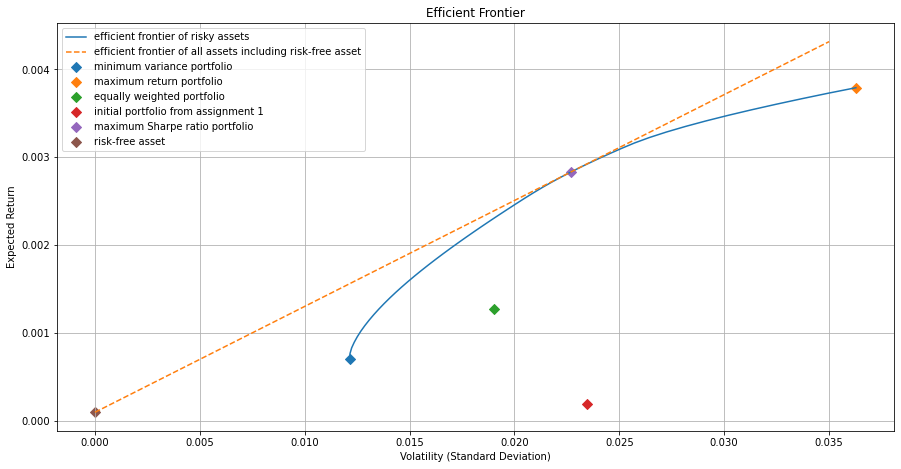

In [20]:
# efficient frontier plot
targetRet = np.linspace(ret_minVar,ret_maxRet,50)

w = cp.Variable(20)
eps = cp.Parameter()
eps.value = targetRet[0]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                 [mu.T@w >= eps,
                  sum(w) == 1,
                  w >= 0])
prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})

w_front = []
var_front = []
ret_front = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
    w_front.append(w.value)
    var_front.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front.append(np.dot(mu, w.value))
    
x_capm = np.linspace(0, 0.035, 50)
y_capm = ((ret_max_sharpe-ret_rf)/np.sqrt(var_max_sharpe))*x_capm + ret_rf
    
ax = plt.gca()
plt.rcParams['figure.figsize'] = [15, 7.5]
ax.plot(np.sqrt(var_front), ret_front, label='efficient frontier of risky assets')
ax.scatter(x=np.sqrt(var_minVar), y=ret_minVar, marker='D', s=50, label='minimum variance portfolio')
ax.scatter(x=np.sqrt(var_maxRet), y=ret_maxRet,  marker='D', s=50, label='maximum return portfolio')
ax.scatter(x=np.sqrt(var_equal_weight), y=ret_equal_weight,  marker='D', s=50, label='equally weighted portfolio')
ax.scatter(x=np.sqrt(var_initial), y=ret_initial,  marker='D', s=50, label='initial portfolio from assignment 1')
ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe,  marker='D', s=50, label='maximum Sharpe ratio portfolio')
ax.scatter(x=0, y=ret_rf,  marker='D', s=50, label='risk-free asset')
ax.plot(x_capm, y_capm, '--', label='efficient frontier of all assets including risk-free asset')
ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
ax.legend()
ax.grid()
plt.show()

### Question 2, part 2

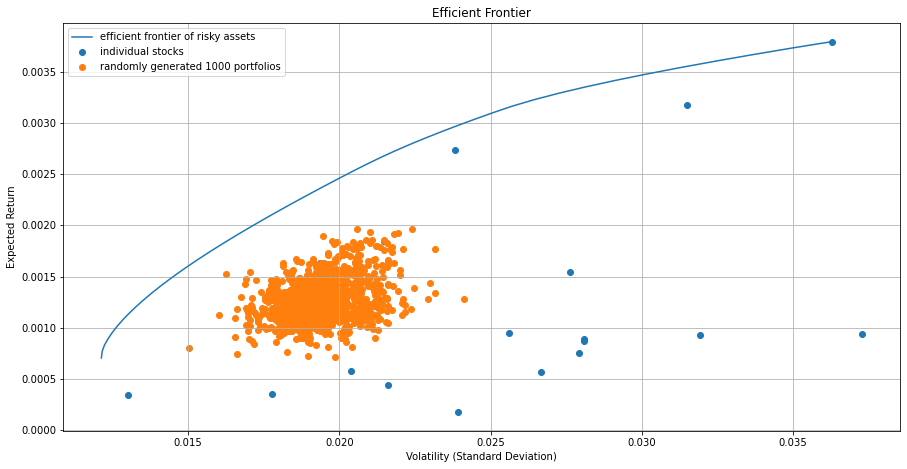

In [21]:
# efficient frontier plot
np.random.seed(1)
var_list = []
ret_list = []
for i in range(1000):
    rand_array = np.random.exponential(size=(20,))
    w = rand_array/np.sum(rand_array)
    var_list.append(np.dot(w, np.dot(Q, w)))
    ret_list.append(np.dot(mu, w))
var_rand = np.asarray(var_list)
ret_rand = np.asarray(ret_list)

ax = plt.gca()
plt.rcParams['figure.figsize'] = [15, 7.5]

ax.plot(np.sqrt(var_front), ret_front, label='efficient frontier of risky assets')
ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, label='individual stocks')
ax.scatter(x=np.sqrt(var_rand), y=ret_rand, label='randomly generated 1000 portfolios')

ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
ax.legend()
ax.grid()
plt.show()

### Question 3, part 1

In [22]:
# Question 3

# Import FF models data from 2019-01-03 to 2020-12-31
input_file_factors  = 'Daily_FF_factors.csv'
if path.exists(input_file_factors):
    print('\nReading daily FF factors datafile - {}\n'.format(input_file_factors))
    ff_data = pd.read_csv(input_file_factors)
    factors_name = list(ff_data.columns)[1:-1]
    rf      = ff_data['RF'][1:]
    factors = ff_data.values[1:,1:4]
else:
    print("No such file '{}'".format(input_file_factors), file=sys.stderr)

# Indicides helpful to seperate data
# dates[day_ind_start_2019] = '01/02/2019',
# dates[day_ind_end_2019] = '12/31/2019',
# dates[day_ind_start_2019] = '01/02/2020',
# dates[day_ind_end_2019] = '12/31/2019'.
day_ind_start_2019 = 0
day_ind_end_2019   = 251
day_ind_start_2020 = 252
day_ind_end_2020   = 504

data_prices_2019   = data_prices[day_ind_start_2019:day_ind_end_2019+1]
data_prices_2020   = data_prices[day_ind_start_2020:day_ind_end_2020+1]


Reading daily FF factors datafile - Daily_FF_factors.csv



In [23]:
# factor loadings and R-squared values for 2019
factors_2019 = factors[day_ind_start_2019:day_ind_end_2019+1]
X_2019 = sm.add_constant(factors_2019)
RHS = X_2019.astype(float)

loading_names = ['alpha','beta_m','beta_s','beta_v','R-squared']
df_2019 = pd.DataFrame(columns=loading_names)
ret_2019 = cur_returns[day_ind_start_2019:day_ind_end_2019+1]
stock_names = fid.columns.tolist()[1:]
for i in range(20):
    i_ret = ret_2019[:,i]
    LHS = i_ret-rf[day_ind_start_2019:day_ind_end_2019+1].to_numpy()
    LHS = LHS.astype(float)
    results = sm.OLS(LHS, RHS).fit()
    df_2019.loc[stock_names[i]] = np.append(results.params, results.rsquared)

print('factor loadings and R-squared values for 2019')
df_2019

factor loadings and R-squared values for 2019


,alpha,beta_m,beta_s,beta_v,R-squared
MSFT,-0.008105,0.012508,-0.004930,-0.005248,0.735844
F,-0.008084,0.010279,0.005270,0.005360,0.322625
JPM,-0.007736,0.011404,-0.003175,0.009947,0.738317
GOOG,-0.008718,0.012082,-0.000519,-0.004448,0.470290
HPQ,-0.009261,0.012507,0.001227,0.002370,0.275263
C,-0.007787,0.015460,-0.001642,0.010711,0.762569
HOG,-0.008723,0.014393,0.004718,0.010647,0.489093
VZ,-0.008341,0.003494,-0.002588,-0.000269,0.078964
AAPL,-0.007391,0.014815,-0.001891,-0.002669,0.547084
IBM,-0.008663,0.010834,-0.002832,0.001893,0.447541


In [24]:
# factor loadings and R-squared values for 2020
factors_2020 = factors[day_ind_start_2020:day_ind_end_2020+1]
X_2020 = sm.add_constant(factors_2020)
RHS = X_2020.astype(float)

df_2020 = pd.DataFrame(columns=loading_names)
ret_2020 = cur_returns[day_ind_start_2020:day_ind_end_2020+1]
for i in range(20):
    i_ret = ret_2020[:,i]
    LHS = i_ret-rf[day_ind_start_2020:day_ind_end_2020+1].to_numpy()
    LHS = LHS.astype(float)
    results = sm.OLS(LHS, RHS).fit()
    df_2020.loc[stock_names[i]] = np.append(results.params, results.rsquared)

print('factor loadings and R-squared values for 2020')
df_2020

factor loadings and R-squared values for 2020


,alpha,beta_m,beta_s,beta_v,R-squared
MSFT,-0.001582,0.012518,-0.002615,-0.005145,0.880827
F,-0.000723,0.008948,0.001273,0.010016,0.646842
JPM,-0.000616,0.010523,-0.002929,0.011202,0.887016
GOOG,-0.001512,0.010155,-0.001221,-0.002578,0.752035
HPQ,-0.001058,0.010589,0.007337,0.003553,0.606785
C,-0.001064,0.012895,-0.000289,0.013293,0.870440
HOG,-0.000656,0.013524,0.003125,0.009001,0.562776
VZ,-0.001542,0.005112,-0.002930,0.001184,0.550817
AAPL,-0.000375,0.012391,-0.004109,-0.004340,0.763150
IBM,-0.001718,0.009248,-0.000535,0.003232,0.723028


In [25]:
# factor loadings and R-squared values for 2019-2020
factors_full = factors
X_full = sm.add_constant(factors_full)
RHS = X_full.astype(float)

df_full = pd.DataFrame(columns=loading_names)
ret_full = cur_returns
for i in range(20):
    i_ret = ret_full[:,i]
    LHS = i_ret-rf.to_numpy()
    LHS = LHS.astype(float)
    results = sm.OLS(LHS, RHS).fit()
    df_full.loc[stock_names[i]] = np.append(results.params, results.rsquared)

print('factor loadings and R-squared values for 2019-2020')
df_full

factor loadings and R-squared values for 2019-2020


,alpha,beta_m,beta_s,beta_v,R-squared
MSFT,-0.004818,0.012503,-0.002833,-0.005240,0.836645
F,-0.004436,0.009341,0.002752,0.009034,0.571292
JPM,-0.004158,0.010692,-0.002539,0.010818,0.854627
GOOG,-0.005081,0.010496,-0.000499,-0.003147,0.650872
HPQ,-0.005003,0.010821,0.006537,0.003249,0.510710
C,-0.004329,0.013317,0.000015,0.012657,0.846797
HOG,-0.004725,0.013625,0.003922,0.008913,0.545291
VZ,-0.005008,0.004959,-0.002654,0.000951,0.380165
AAPL,-0.003882,0.012705,-0.003073,-0.004534,0.693281
IBM,-0.005112,0.009488,-0.000553,0.002850,0.648105


In [26]:
# differences in R-squared value between 2019 and 2020
df_diff = pd.DataFrame(index=stock_names)
df_diff['2019 R-squared value'] = df_2019['R-squared']
df_diff['2020 R-squared value'] = df_2020['R-squared']
df_diff['difference (2020-2019)'] = df_2020['R-squared']-df_2019['R-squared']

In [27]:
df_diff

,2019 R-squared value,2020 R-squared value,difference (2020-2019)
MSFT,0.735844,0.880827,0.144982
F,0.322625,0.646842,0.324217
JPM,0.738317,0.887016,0.148698
GOOG,0.470290,0.752035,0.281746
HPQ,0.275263,0.606785,0.331522
C,0.762569,0.870440,0.107871
HOG,0.489093,0.562776,0.073683
VZ,0.078964,0.550817,0.471853
AAPL,0.547084,0.763150,0.216066
IBM,0.447541,0.723028,0.275487


### Question 3, part 2

In [28]:
# Monte-Carlo simulation for MSFT
np.random.seed(1001)
N_scenarios = 1000
N_steps = 504
rho = np.asarray([[2.6999,0.1351,0.4893],
                  [0.1351,0.5005,0.217],
                  [0.4893,0.217,1.479]])
sqrt_rho = np.linalg.cholesky(rho)
rf_list = rf.tolist()

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value = data_prices[0,0]*100
    
    for i in range(N_steps):
        nr_vec = np.random.randn(3,1)
        step_array = np.dot(sqrt_rho,nr_vec).T
        fm, fs, fv = step_array[0][0], step_array[0][1], step_array[0][2]
        ret_i = rf_list[i] + df_full.loc['MSFT']['alpha'] + df_full.loc['MSFT']['beta_m']*fm + df_full.loc['MSFT']['beta_s']*fs + df_full.loc['MSFT']['beta_v']*fv
        PL_i = ret_i*portf_value
        PLData_list.append(PL_i)
        portf_value = portf_value + PL_i
    loss_MSFT = np.sort(-np.asarray(PLData_list))
    N = len(PLData_list)
    VaR_mc = loss_MSFT[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR_mc)
    
var_MSFT = np.asarray(var_list).mean()

In [29]:
# Monte Carlo simulation for AAPL
np.random.seed(505001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value = data_prices[0,8]*200
    
    for i in range(N_steps):
        nr_vec = np.random.randn(3,1)
        step_array = np.dot(sqrt_rho,nr_vec).T
        fm, fs, fv = step_array[0][0], step_array[0][1], step_array[0][2]
        ret_i = rf_list[i] + df_full.loc['AAPL']['alpha'] + df_full.loc['AAPL']['beta_m']*fm + df_full.loc['AAPL']['beta_s']*fs + df_full.loc['AAPL']['beta_v']*fv
        PL_i = ret_i*portf_value
        PLData_list.append(PL_i)
        portf_value = portf_value + PL_i
    loss_AAPL = np.sort(-np.asarray(PLData_list))
    N = len(PLData_list)
    VaR_mc = loss_AAPL[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR_mc)
    
var_AAPL = np.asarray(var_list).mean()

In [30]:
# Monte Carlo simulation for IBM
np.random.seed(1009001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value = data_prices[0,9]*500
    
    for i in range(N_steps):
        nr_vec = np.random.randn(3,1)
        step_array = np.dot(sqrt_rho,nr_vec).T
        fm, fs, fv = step_array[0][0], step_array[0][1], step_array[0][2]
        ret_i = rf_list[i] + df_full.loc['IBM']['alpha'] + df_full.loc['IBM']['beta_m']*fm + df_full.loc['IBM']['beta_s']*fs + df_full.loc['IBM']['beta_v']*fv
        PL_i = ret_i*portf_value
        PLData_list.append(PL_i)
        portf_value = portf_value + PL_i
    loss_IBM = np.sort(-np.asarray(PLData_list))
    N = len(PLData_list)
    VaR_mc = loss_IBM[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR_mc)
    
var_IBM = np.asarray(var_list).mean()

In [31]:
# Monte Carlo simulation for whole portfolio
np.random.seed(1513001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value1 = data_prices[0,0]*100
    portf_value2 = data_prices[0,8]*200
    portf_value3 = data_prices[0,9]*500
    
    for i in range(N_steps):
        nr_vec1 = np.random.randn(3,1)
        nr_vec2 = np.random.randn(3,1)
        nr_vec3 = np.random.randn(3,1)
        step_array1 = np.dot(sqrt_rho,nr_vec1).T
        step_array2 = np.dot(sqrt_rho,nr_vec2).T
        step_array3 = np.dot(sqrt_rho,nr_vec3).T
        fm1, fs1, fv1 = step_array1[0][0], step_array1[0][1], step_array1[0][2]
        fm2, fs2, fv2 = step_array2[0][0], step_array2[0][1], step_array2[0][2]
        fm3, fs3, fv3 = step_array3[0][0], step_array3[0][1], step_array3[0][2]
        ret_i1 = rf_list[i] + df_full.loc['MSFT']['alpha'] + df_full.loc['MSFT']['beta_m']*fm1 + df_full.loc['MSFT']['beta_s']*fs1 + df_full.loc['MSFT']['beta_v']*fv1
        ret_i2 = rf_list[i] + df_full.loc['AAPL']['alpha'] + df_full.loc['AAPL']['beta_m']*fm2 + df_full.loc['AAPL']['beta_s']*fs2 + df_full.loc['AAPL']['beta_v']*fv2
        ret_i3 = rf_list[i] + df_full.loc['IBM']['alpha'] + df_full.loc['IBM']['beta_m']*fm3 + df_full.loc['IBM']['beta_s']*fs3 + df_full.loc['IBM']['beta_v']*fv3
        PL_i1, PL_i2, PL_i3 = ret_i1*portf_value1, ret_i2*portf_value2, ret_i3*portf_value3
        PLData_list.append(PL_i1 + PL_i2 + PL_i3)
        portf_value1 = portf_value1 + PL_i1
        portf_value2 = portf_value2 + PL_i2
        portf_value3 = portf_value3 + PL_i3
    loss_whole = np.sort(-np.asarray(PLData_list))
    N = len(PLData_list)
    VaR_mc = loss_whole[int(math.ceil(N * alf)) - 1]
    var_list.append(VaR_mc)
    
var_whole = np.asarray(var_list).mean()

In [32]:
print('100 MSFT stocks Monte Carlo 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_MSFT))
print('200 AAPL stocks Monte Carlo 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_AAPL))
print('500 IBM stocks Monte Carlo 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_IBM))
print('Whole portfolio Monte Carlo 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_whole))

100 MSFT stocks Monte Carlo 1-day VaR 95.0% = $644.15

200 AAPL stocks Monte Carlo 1-day VaR 95.0% = $666.41

500 IBM stocks Monte Carlo 1-day VaR 95.0% = $2679.15

Whole portfolio Monte Carlo 1-day VaR 95.0% = $2881.98



In [33]:
# using normal distribution model for MSFT
np.random.seed(2017001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value = data_prices[0,0]*100
    
    for i in range(N_steps):
        nr_vec = np.random.randn(3,1)
        step_array = np.dot(sqrt_rho,nr_vec).T
        fm, fs, fv = step_array[0][0], step_array[0][1], step_array[0][2]
        ret_i = rf_list[i] + df_full.loc['MSFT']['alpha'] + df_full.loc['MSFT']['beta_m']*fm + df_full.loc['MSFT']['beta_s']*fs + df_full.loc['MSFT']['beta_v']*fv
        PL_i = ret_i*portf_value
        PLData_list.append(PL_i)
        portf_value = portf_value + PL_i
    loss_MSFT = np.sort(-np.asarray(PLData_list))
    VaR_mc = np.mean(loss_MSFT) + scs.norm.ppf(alf) * np.std(loss_MSFT)
    var_list.append(VaR_mc)
    
var_MSFT_n = np.asarray(var_list).mean()

In [34]:
# using normal distribution model for AAPL
np.random.seed(2521001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value = data_prices[0,8]*200
    
    for i in range(N_steps):
        nr_vec = np.random.randn(3,1)
        step_array = np.dot(sqrt_rho,nr_vec).T
        fm, fs, fv = step_array[0][0], step_array[0][1], step_array[0][2]
        ret_i = rf_list[i] + df_full.loc['AAPL']['alpha'] + df_full.loc['AAPL']['beta_m']*fm + df_full.loc['AAPL']['beta_s']*fs + df_full.loc['AAPL']['beta_v']*fv
        PL_i = ret_i*portf_value
        PLData_list.append(PL_i)
        portf_value = portf_value + PL_i
    loss_AAPL = np.sort(-np.asarray(PLData_list))
    VaR_mc = np.mean(loss_AAPL) + scs.norm.ppf(alf) * np.std(loss_AAPL)
    var_list.append(VaR_mc)
    
var_AAPL_n = np.asarray(var_list).mean()

In [35]:
# using normal distribution model for IBM
np.random.seed(3025001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value = data_prices[0,9]*500
    
    for i in range(N_steps):
        nr_vec = np.random.randn(3,1)
        step_array = np.dot(sqrt_rho,nr_vec).T
        fm, fs, fv = step_array[0][0], step_array[0][1], step_array[0][2]
        ret_i = rf_list[i] + df_full.loc['IBM']['alpha'] + df_full.loc['IBM']['beta_m']*fm + df_full.loc['IBM']['beta_s']*fs + df_full.loc['IBM']['beta_v']*fv
        PL_i = ret_i*portf_value
        PLData_list.append(PL_i)
        portf_value = portf_value + PL_i
    loss_IBM = np.sort(-np.asarray(PLData_list))
    VaR_mc = np.mean(loss_IBM) + scs.norm.ppf(alf) * np.std(loss_IBM)
    var_list.append(VaR_mc)
    
var_IBM_n = np.asarray(var_list).mean()

In [36]:
# using normal distribution model for whole portfolio
np.random.seed(3529001)

var_list = []
for s in range(N_scenarios):
    PLData_list = []
    portf_value1 = data_prices[0,0]*100
    portf_value2 = data_prices[0,8]*200
    portf_value3 = data_prices[0,9]*500
    
    for i in range(N_steps):
        nr_vec1 = np.random.randn(3,1)
        nr_vec2 = np.random.randn(3,1)
        nr_vec3 = np.random.randn(3,1)
        step_array1 = np.dot(sqrt_rho,nr_vec1).T
        step_array2 = np.dot(sqrt_rho,nr_vec2).T
        step_array3 = np.dot(sqrt_rho,nr_vec3).T
        fm1, fs1, fv1 = step_array1[0][0], step_array1[0][1], step_array1[0][2]
        fm2, fs2, fv2 = step_array2[0][0], step_array2[0][1], step_array2[0][2]
        fm3, fs3, fv3 = step_array3[0][0], step_array3[0][1], step_array3[0][2]
        ret_i1 = rf_list[i] + df_full.loc['MSFT']['alpha'] + df_full.loc['MSFT']['beta_m']*fm1 + df_full.loc['MSFT']['beta_s']*fs1 + df_full.loc['MSFT']['beta_v']*fv1
        ret_i2 = rf_list[i] + df_full.loc['AAPL']['alpha'] + df_full.loc['AAPL']['beta_m']*fm2 + df_full.loc['AAPL']['beta_s']*fs2 + df_full.loc['AAPL']['beta_v']*fv2
        ret_i3 = rf_list[i] + df_full.loc['IBM']['alpha'] + df_full.loc['IBM']['beta_m']*fm3 + df_full.loc['IBM']['beta_s']*fs3 + df_full.loc['IBM']['beta_v']*fv3
        PL_i1, PL_i2, PL_i3 = ret_i1*portf_value1, ret_i2*portf_value2, ret_i3*portf_value3
        PLData_list.append(PL_i1 + PL_i2 + PL_i3)
        portf_value1 = portf_value1 + PL_i1
        portf_value2 = portf_value2 + PL_i2
        portf_value3 = portf_value3 + PL_i3
    loss_whole = np.sort(-np.asarray(PLData_list))
    VaR_mc = np.mean(loss_whole) + scs.norm.ppf(alf) * np.std(loss_whole)
    var_list.append(VaR_mc)
    
var_whole_n = np.asarray(var_list).mean()

In [37]:
print('100 MSFT stocks normal distribution model 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_MSFT_n))
print('200 AAPL stocks normal distribution model 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_AAPL_n))
print('500 IBM stocks normal distribution model 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_IBM_n))
print('Whole portfolio normal distribution model 1-day VaR %4.1f%% = $%6.2f\n'% (100*alf, var_whole_n))

100 MSFT stocks normal distribution model 1-day VaR 95.0% = $648.08

200 AAPL stocks normal distribution model 1-day VaR 95.0% = $645.34

500 IBM stocks normal distribution model 1-day VaR 95.0% = $2694.18

Whole portfolio normal distribution model 1-day VaR 95.0% = $2869.84



In [45]:
df_output3 = pd.DataFrame(columns=['MSFT','AAPL','IBM','Whole portfolio','MSFT (normal)','AAPL (normal)','IBM (normal)','Whole portfolio (normal)'])
df_output3.loc['Historical method (Q1)'] = [VaR1_MSFT,VaR1_AAPL,VaR1_IBM,VaR1,VaR1_MSFT_n,VaR1_AAPL_n,VaR1_IBM_n,VaR1n]
df_output3.loc['Monte Carlo method (Q3)'] = [var_MSFT,var_AAPL,var_IBM,var_whole,var_MSFT_n,var_AAPL_n,var_IBM_n,var_whole_n]
df_output3

,MSFT,AAPL,IBM,Whole portfolio,MSFT (normal),AAPL (normal),IBM (normal),Whole portfolio (normal)
Historical method (Q1),531.608580,564.248658,1837.72660,2477.252192,556.210053,592.791219,1936.142107,2646.491831
Monte Carlo method (Q3),644.150028,666.412185,2679.15496,2881.981961,648.078728,645.336575,2694.180894,2869.844882


In [46]:
df_output4 = pd.DataFrame(columns=['VaR(Portfolio)','VaR(MSFT) + VaR(AAPL) + VaR(IBM)'])
df_output4.loc['Historical method'] = [var_whole,var_MSFT+var_AAPL+var_IBM]
df_output4.loc['Normal method'] = [var_whole_n,var_MSFT_n+var_AAPL_n+var_IBM_n]
df_output4

,VaR(Portfolio),VaR(MSFT) + VaR(AAPL) + VaR(IBM)
Historical method,2881.981961,3989.717173
Normal method,2869.844882,3987.596197
